In [14]:
# Clustering of timeseries data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tsfresh import extract_features
from dynamic_time_warping import Preprocessing


Read in the master csv/df

In [2]:
df = pd.read_csv('complete_df_7.csv')

/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (8,9,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
df.head()

,store_key,sku_key,tran_date,sales,selling_price,avg_discount,promotion_type,store_region,store_grading,store_area_manager,sku_department,sku_subdepartment,sku_category,sku_subcategory,sku_range,sku_label,stock_open
0,121,47364,2017-11-06,1,0.01,0.0,no_promotion,WC,B,WA,AM,AG,150,209,0001A,Gift C,-1.0
1,119,60063,2018-02-21,21,0.01,0.0,no_promotion,GTN,NaN,SI2014,AM,PA,100,201,0001A,001,-2027.0
2,36,53252,2017-09-30,0,0.01,0.0,no_promotion,GTN,B,SI2014,AM,AB,49,049,0001A,001,0.0
3,118,60064,2017-11-28,27,0.01,0.0,no_promotion,NW,NaN,CH2014,AM,PA,100,201,0001A,001,-1356.0
4,118,60064,2017-11-27,22,0.01,0.0,no_promotion,NW,NaN,CH2014,AM,PA,100,201,0001A,001,-1334.0


In [4]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [8]:
df['stock_open'] = df['stock_open'].astype(float)

Do product level aggregates

In [9]:
aggregate = df.groupby(['sku_key', 'tran_date']).agg({'sales':'sum', 'selling_price':'mean',
                                                      'avg_discount': 'mean', 'stock_open': 'sum'})
aggregate.reset_index(inplace=True)

In [10]:
categorical = df[['sku_key', 'sku_department', 'sku_subdepartment',
                  'sku_category', 'sku_subcategory', 'sku_label']]

In [11]:
nw_df = pd.DataFrame([], columns=['sku_key','sku_department','sku_subdepartment','sku_category','sku_subcategory', 'sku_label'])
for i in categorical['sku_key'].unique():
    nw_df = pd.concat([nw_df, pd.DataFrame(categorical[categorical['sku_key'] == i].iloc[0]).T])

In [14]:
nw_df.reset_index(inplace=True, drop=True)

In [15]:
aggregate['sku_key'] = aggregate['sku_key'].astype(int)
nw_df['sku_key'] = nw_df['sku_key'].astype(int)

In [16]:
aggregate_df = aggregate.merge(nw_df, how='left', on='sku_key')

In [17]:
aggregate_df.head()

,sku_key,tran_date,sales,selling_price,avg_discount,stock_open,sku_department,sku_subdepartment,sku_category,sku_subcategory,sku_label
0,28,2016-03-02,1,89.9,0.0,64.0,TY,06,063,20G,DRGI
1,28,2016-03-03,0,89.9,0.0,63.0,TY,06,063,20G,DRGI
2,28,2016-03-04,0,89.9,0.0,63.0,TY,06,063,20G,DRGI
3,28,2016-03-05,0,89.9,0.0,63.0,TY,06,063,20G,DRGI
4,28,2016-03-06,0,89.9,0.0,63.0,TY,06,063,20G,DRGI


In [21]:
aggregate_df.to_csv('aggregate_products.csv', index=False)

In [22]:
aggregate_df['tran_date'] = pd.to_datetime(df['tran_date'])

Extract features using tsfresh

In [23]:
extracted_features = extract_features(aggregate_df[['sku_key', 'tran_date', 'sales']], column_id="sku_key", column_sort="tran_date")

Feature Extraction: 100%|██████████| 10/10 [1:30:59<00:00, 317.45s/it] 


In [24]:
extracted_features.to_csv('extracted_features.csv')

In [26]:
categorical = aggregate_df[['sku_key', 'sku_department',
                   'sku_subdepartment', 'sku_category', 'sku_subcategory', 'sku_label']]

nw_df = pd.DataFrame([], columns=['sku_key','sku_department','sku_subdepartment','sku_category','sku_subcategory', 'sku_label'])
for i in categorical['sku_key'].unique():
    nw_df = pd.concat([nw_df, pd.DataFrame(categorical[categorical['sku_key'] == i].iloc[0]).T])
    
nw_df.reset_index(inplace=True, drop=True)
nw_df.to_csv('sku_labels.csv', index=False)

In [10]:
pp = Preprocessing()
pivot_table = pp.pivot_table(aggregate_df)
sorted_df = pp.sort_nas(pivot_table)
pp.make_diff_length_list(sorted_df)

Manipulate and pivot table...
There are 1122 products with less than 50% entries


In [27]:
pivot_nans, nans, pivot_no_nans, no_nans = pp.split_nans(pivot_table, extracted_features)

In [29]:
pivot_nans.to_csv('nans_pivot_table.csv')
pivot_no_nans.to_csv('no_nans_pivot_table.csv')
nans.to_csv('extracted_feat_nans.csv')
no_nans.to_csv('extracted_feat_no_nans.csv')

Have a look at the coverage of the time series'

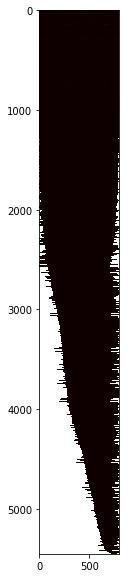

In [12]:
pp.plot_nas(sorted_df)